In [286]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection
import xgboost as xgb
from xgboost import XGBClassifier,plot_importance
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score,roc_curve,brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [287]:
data=pd.read_csv(r"C:\Users\Sid\Desktop\vit\DataScience Projects\Credit risk management\credit_risk_dataset.csv")
dimension=data.columns

In [288]:
data.head()

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

In [289]:
data.tail()

person_age  person_income person_home_ownership  person_emp_length  \
32576          57          53000              MORTGAGE                1.0   
32577          54         120000              MORTGAGE                4.0   
32578          65          76000                  RENT                3.0   
32579          56         150000              MORTGAGE                5.0   
32580          66          42000                  RENT                2.0   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
32576         PERSONAL          C       5800          13.16            0   
32577         PERSONAL          A      17625           7.49            0   
32578  HOMEIMPROVEMENT          B      35000          10.99            1   
32579         PERSONAL          B      15000          11.48            0   
32580          MEDICAL          B       6475           9.99            0   

       loan_percent_income cb_person_default_on_file  \
32576                 0.11                         N   
32577                 0.15                         N   
32578                 0.46                         N   
32579                 0.10                         N   
32580                 0.15                         N   

       cb_person_cred_hist_length  
32576                          30  
32577                          19  
32578                          28  
32579                          26  
32580                          30

In [290]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [291]:
data.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [292]:
#Dropping missing values
data = data.dropna(axis=0)

In [293]:
#Scatterplot matrix
fig = px.scatter_matrix(data, dimensions=
["person_age","person_income","person_emp_length","loan_amnt","loan_int_rate"],
labels={col:col.replace('_', ' ') for col in data.columns},           
height=900, color="loan_status", color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()


In [294]:
#Removing outliers
data = data[data["person_age"]<=100]
data = data[data["person_emp_length"]<=100]
data = data[data["person_income"]<= 4000000]

In [295]:
#Percentage of non-default cases
data_0 = data[data.loan_status == 0].loan_status.count() / data.loan_status.count()
data_0

0.7833892148644873

In [296]:
#Box plot
fig = px.box(data, x="loan_grade", y="loan_percent_income", color="loan_grade",
color_discrete_sequence=px.colors.qualitative.Dark24,
labels={col:col.replace('_', ' ') for col in data.columns},
category_orders={"loan_grade":["A","B","C","D","E","F","G"]})
fig.update_layout(legend=dict(orientation="h", yanchor="bottom",
y=1.02, xanchor="right", x=1))
fig.show()

In [297]:
#Parallel category diagram
fig = px.parallel_categories(data, color_continuous_scale=px.colors.sequential.RdBu, color="loan_status",
dimensions=['person_home_ownership', 'loan_intent', "loan_grade", 'cb_person_default_on_file'], labels={col:col.replace('_', ' ') for col in data.columns})
fig.show()

In [298]:
#One hot encoding of categorical variables
df = pd.get_dummies(data=data,columns=['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file'])

In [299]:
#Train and test split
Y = df['loan_status']
X = df.drop('loan_status',axis=1)
x_train, x_test, y_train, y_test =train_test_split(X, Y, random_state=0, test_size=.20)

In [300]:
# Create classifiers
knn = KNeighborsClassifier(n_neighbors=151)
logreg = LogisticRegression(random_state=0)
xgb = XGBClassifier()

In [301]:
# Train classifiers
knn.fit(x_train, y_train)
logreg.fit(x_train, y_train)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [303]:
#Predict using the test set
knn_pred=knn.predict(x_test)
logreg_pred=logreg.predict(x_test)
xgb_pred=xgb.predict(x_test)

In [304]:
print(classification_report(y_test,knn_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.90      4525
           1       0.72      0.39      0.51      1202

    accuracy                           0.84      5727
   macro avg       0.79      0.68      0.71      5727
weighted avg       0.83      0.84      0.82      5727



In [305]:
print(classification_report(y_test,logreg_pred))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      4525
           1       0.72      0.17      0.27      1202

    accuracy                           0.81      5727
   macro avg       0.77      0.58      0.58      5727
weighted avg       0.80      0.81      0.76      5727



In [306]:
print(classification_report(y_test,xgb_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4525
           1       0.95      0.74      0.83      1202

    accuracy                           0.94      5727
   macro avg       0.94      0.87      0.90      5727
weighted avg       0.94      0.94      0.94      5727



In [307]:
# Get predicted probabilities for test set
y_pred_proba_knn = knn.predict_proba(x_test)[:, 1]
y_pred_proba_logreg = logreg.predict_proba(x_test)[:, 1]
y_pred_proba_xgb = xgb.predict_proba(x_test)[:, 1]

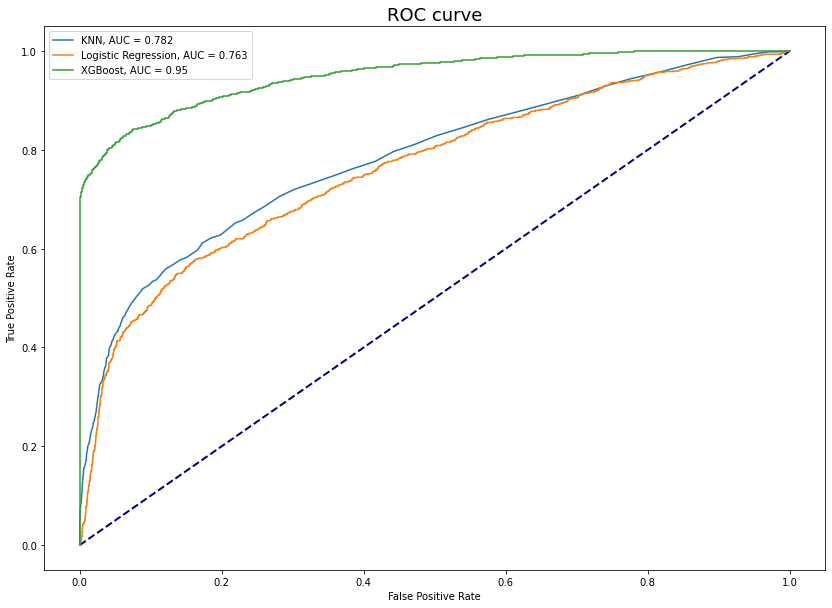

In [308]:
#ROC AUC
fig = plt.figure(figsize=(14,10))
plt.plot([0, 1], [0, 1],color='navy', lw=2, linestyle='--')

#KNN
preds_proba_knn = knn.predict_proba(x_test)
fpr, tpr, thresh = metrics.roc_curve(y_test,y_pred_proba_knn )
aucknn = roc_auc_score(y_test,y_pred_proba_knn )
plt.plot(fpr, tpr, label=f'KNN, AUC = {str(round(aucknn,3))}')

#Logistic Regression
preds_proba_logreg = logreg.predict_proba(x_test)
fpr, tpr, thresh = metrics.roc_curve(y_test,y_pred_proba_logreg )
auclg = roc_auc_score(y_test, y_pred_proba_logreg)
plt.plot(fpr, tpr, label=f'Logistic Regression, AUC = {str(round(auclg,3))}')

#XGBoost
preds_proba_xgb = xgb.predict_proba(x_test)
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_proba_xgb)
aucxgb = roc_auc_score(y_test, y_pred_proba_xgb)
plt.plot(fpr, tpr, label=f'XGBoost, AUC = {str(round(aucxgb,3))}')



plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC curve")
plt.rcParams['axes.titlesize'] = 18
plt.legend()
plt.show()

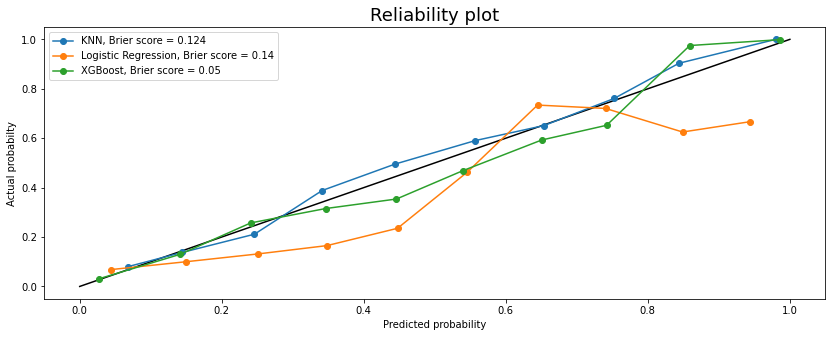

In [319]:
#Reliability plot and Brier Score
fig = plt.figure(figsize=(14,5))
plt.plot([0, 1], [0, 1], color="black")

#KNN
knn_y, knn_x = calibration_curve(y_test, preds_proba_knn[:,1], n_bins=10, normalize=True)
loss_knn = brier_score_loss(y_test, preds_proba_knn[:,1])
plt.plot(knn_x, knn_y, marker='o', label=f'KNN, Brier score = {str(round(loss_knn,3))}')

#Logistic Regression
lg_y, lg_x = calibration_curve(y_test, preds_proba_lg[:,1], n_bins=10, normalize=True)
loss_lg = brier_score_loss(y_test, preds_proba_lg[:,1])
plt.plot(lg_x, lg_y, marker='o',label=f'Logistic Regression, Brier score = {str(round(loss_lg,3))}')

#XGBoost
preds_proba_xgb = xgb.predict_proba(x_test)
xgb_y, xgb_x = calibration_curve(y_test, preds_proba_xgb[:,1], n_bins=10, normalize=True)
loss_xgb = brier_score_loss(y_test, preds_proba_xgb[:,1])
plt.plot(xgb_x, xgb_y, marker='o', label=f'XGBoost, Brier score = {str(round(loss_xgb,3))}')


plt.ylabel("Actual probabilty")
plt.xlabel("Predicted probability")
plt.title("Reliability plot")
plt.rcParams['axes.titlesize'] = 18
plt.legend()
plt.show()


Text(0.5, 0, 'Gain')

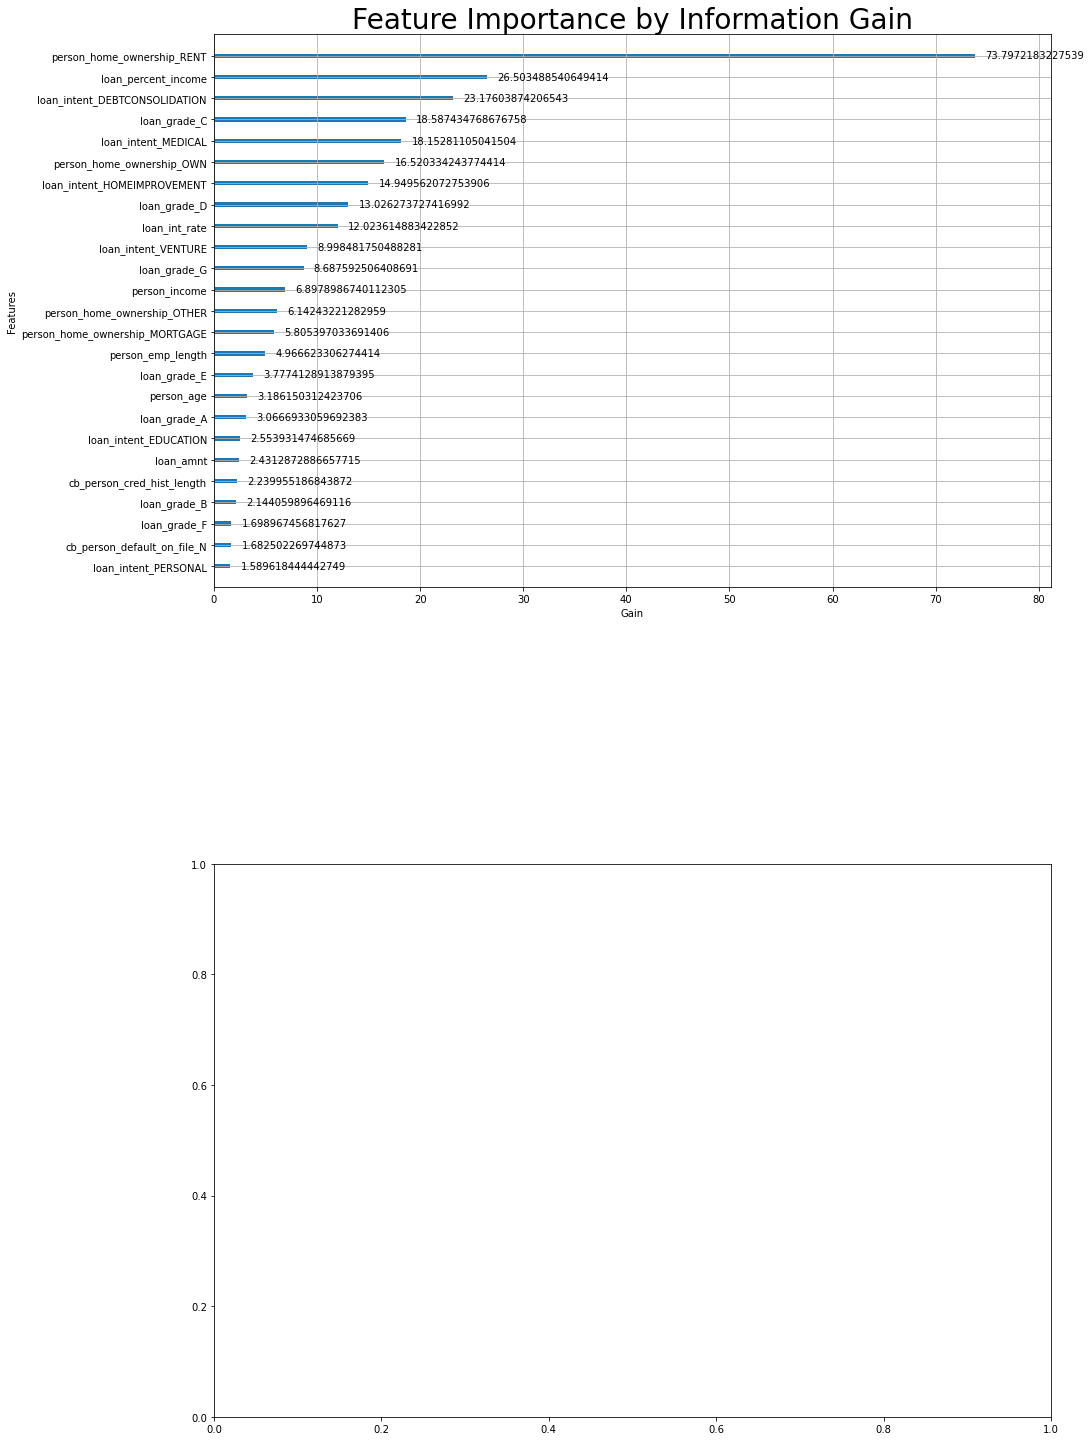

In [331]:
#Feature importance plot

fig, (ax1, ax2) = plt.subplots(figsize = (15, 24), ncols=1, nrows=2)
plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top = 0.9, wspace=0, hspace = 0.5)
plot_importance(xgb, importance_type='gain', ax = ax1)
ax1.set_title('Feature Importance by Information Gain', fontsize = 28)
ax1.set_xlabel('Gain')